<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

In [3]:
class PretrainTest():
    def __init__(self, weight_read, holes = 0, inputs_type = (1, 0), size = 15):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.pregame.net.load_state_dict(torch.load(weight_read))
        self.game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[1])
        self.weight = weight_read
        
            
    def decode(self, weight = None):
        if weight != None:
            self.pregame.net.load_state_dict(torch.load(weight))
        else:
             self.pregame.net.load_state_dict(torch.load(self.weight))
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.net.cpu()
        self.game.experiment(rls_q, rls_sl,20, epsilon = 0.5, train_hidden = False, train_q = False, size_range=(15, 16), test = True) 
        def precision():
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0)[0])
            prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
            prec2 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1)[0])
            return (prec0 + prec1 + prec2)/3, (prec2 - prec0)
        print ('decode train finish')
        Prec, dif = precision()
        print ('decode end', Prec, 'dif decode', dif)
        return Prec, dif
        # q learning session 
    
    
    def TestAllSizes(self, size_range = np.arange(15, 86, 10), limit_set = 8, test_size = None):
        self.game.net.load_state_dict(torch.load(self.weight))
        self.Performance = []
        for size in size_range:
            if test_size == None: 
                test_size = size//25
            else:
                test_size = test_size
            Rewards0 = Test(self.game, reward_control = 0, size = size, test = test_size, limit_set = limit_set)
            Rewards1 = Test(self.game, reward_control = 1, size = size, test = test_size, limit_set = limit_set)
            self.Performance.append((Rewards0 + Rewards1)/2)

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

If look carefully, the slow timescale here is a very long transient,  it will not return to baseline in a very long run of game, that is different from gru, which maintains a baseline.  If the system is a true integrator,  it should not loose the baseline, because there is no concept of return in this case. 

The very slow timescale could make the system harder to reset, except I use a strong input.  So reset upon input and remember is always contradictory.  If I design a task also need to pay attention to fast timescale , this will fail more throughly 

# Timescale, Spatial Information & Performance

In [4]:
# attention to noise level, here corresponed to pretraining , so set noise to 1 
def trajectory(game, pos0, reward_control = 0, init_hidden = True, hidden = torch.zeros(512, 512), size = 19, test = 2):
    game.reset(set_agent = pos0, reward_control = reward_control, size = size, limit_set = 32, test = test)
    done = False
    if init_hidden == True:
        game.hidden = game.net.initHidden()
    else:
        game.hidden = hidden.clone()
    hidden0 = game.hidden.clone()
    Hidden = []
    dH = []
    Action = []
    State = []
    Pos = []
    Pos.append(game.agent.pos)
    while not done:
        pos0, state, reward, done = game.step(game.maxplay, epsilon = 0.00, test=True) # Down
        Hidden.append(game.hidden.data.numpy().squeeze())
        dH.append(torch.norm(game.hidden - hidden0))
        Pos.append(game.agent.pos)
        Action.append(np.argmax(game.action.data.numpy()))
        State.append(state)
        hidden0 = game.hidden.clone()
    return Pos, np.array(Hidden), np.array(dH), np.array(Action), reward

def trajectory_empty(pos0, game, T = 50, T0 = 100, Time_stop = 60, reward_control = 0, action_ = 0, e = 0, open_loop = True):
    game.reset(reward_control = reward_control, size = 15)
    done = False
    game.hidden = game.net.initHidden()
    game.action = torch.zeros(1, 4)
    Hidden = []
    Action = []
    Pos = []
    dH = []
    hidden0 = game.hidden.clone()
    game.agent.pos = pos0 
    stim = game.visible_state 
#     print (game.visible_state)
    y, x = 0, 0
    action = action_
    while not done:
        if open_loop == True:
            done, action = game.step_empty(stim = stim, action_ = action_, epsilon = e, T = T, T0 = T0, time_stop = Time_stop, open_loop = open_loop) # Down
        else:
            done, action = game.step_empty(stim = stim, action_ = action, epsilon = e, T = T, T0 = T0, time_stop = Time_stop, open_loop = open_loop) # Down
        # up 
        if action == 0: y -= 1
        # right
        elif action == 1: x += 1
        # down
        elif action == 2: y += 1
        # left
        elif action == 3: x -= 1
        game.agent.pos = (y, x)
        Pos.append(game.agent.pos)
        Hidden.append(game.hidden.clone().data.numpy().squeeze()) # need copy , avoid same adress 
        dH.append(torch.norm(game.hidden - hidden0))
        Action.append(action)
        hidden0 = game.hidden.clone()
    dH = [dh.data.numpy() for dh in dH]
    return Pos, np.array(Hidden), np.array(dH), np.array(Action)


class PCA():
    def __init__(self, size = 15, reward_control = 0, trial = 0, file = 1, iters1 = 0, iters2 = 9, epsilon = 1):
        self.epsilon = epsilon
        self.Hiddens = np.zeros((225, 50, 512))
        self.reward_control = reward_control
        self.weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
        self.game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, 
                                 discount = 0.9, alpha = 1, time_limit=100, lam = 0.5)
        self.game.net.load_state_dict(torch.load(self.weight))
        self.trial = trial
    # record hidden activity, attention take test = true
    def record(self):
        for j in range (2,17):
            for i in range (2,17):
                self.game.reset(set_agent = (j,i), reward_control = self.reward_control, size = 15)
                done = False
                self.game.hidden = self.game.net.initHidden()
                for t in range(50):
                    pos0, state, reward, done = self.game.step(self.game.maxplay, epsilon = self.epsilon, test = True) # Down
                    self.Hiddens[(j-2) * 15 + (i-2), t] = (self.game.hidden.data.numpy().squeeze())
                    if done == True:
                        self.game.reset(reward_control = self.reward_control, size = 15)
                        done = False 
    # put every row(time) together into one long trajectory, which means concatenation along rows - number of neurons
    def pca(self):
        self.record()
        Trajectory = self.Hiddens.reshape(225 * 50, 512)
        #  take correlation out
        def minus(a):
            return (a - a.mean())/(a.std() + 1e-5)
        # standarlization along columns which is one specific neural activity trace for all time
        activity = np.apply_along_axis(minus, 1, Trajectory)
        cov = activity.T@activity
        # take eign vector and values
        self.vals, self.vect = np.linalg.eig(cov)
        
    def TimeScale(self, plot = False, T_total = 800, Hiddens = [], noise = 2, iters = 4, Actions = [2, 0, 1, 3], e = 0, T0 = 100, Time_stop = 60, same = True, legend = False, corner = False, open_loop = True, readout_random = False) :
        Attractors = []
        Timescale = []
        Trajectory = []
        Positions = []
        # take pca for specific game 
        Ts = []
        pos_dict = [('up',(2,9)), ('down', (16,9)), ('left', (9,2)), ('right',(9,16)), ('upleft',(2,2)), ('upright',(2,16)), ('downleft', (16,2)), ('downright', (16,16)), ('reward', (9,12)), ('empty', (5, 5))]
        colors = ['r', 'g', 'b', 'm', 'c']
        k = 0
        if readout_random == True and open_loop == False:
            self.game.net.h2o = nn.Parameter(torch.randn(512, 4) * 0.01 * np.sqrt(2.0/(512+4)))
        # all stimulus for specific actions 
        for iters, pos in enumerate(pos_dict):
            for action in Actions:
                pos0 = pos[1]
                Pos1, hidden1, dh1, actions = trajectory_empty(pos0, self.game, T = T_total, T0 = T0, action_ = action, e = e, Time_stop = Time_stop, open_loop = open_loop)
                Ts.append(np.sum((dh1[T0:]>1e-1)))
        #         print ('timescale', np.sum(dh1>1))
                PC_traces = self.vect[:10] @ hidden1.T
                Trajectory.append(PC_traces[0][100:])
                Positions.append(Pos1[100:])
                Hiddens.append((hidden1, pos[0]))
#                 if np.sum((dh1[T0:]>1e-1))<300:
                Attractors.append(PC_traces[:5, -1])
                if plot == True:
                    if same == False:
                        plt.figure(k)
                    else:
                        plt.figure(0)
                    if corner == False:
                        if (pos[0] == 'up') or (pos[0] == 'down') or (pos[0] == 'left') or (pos[0] == 'right') or (pos[0] == 'empty'):
                            plt.plot(PC_traces[0], label = pos[0] + str(self.trial), color = colors[k], alpha = 0.5 + 0.1 * k)
                            k += 1
                            if legend == True:
                                plt.legend()
                    else:
                        if (pos[0] == 'upleft') or (pos[0] == 'downleft') or (pos[0] == 'upright') or (pos[0] == 'downright') or (pos[0] == 'empty'):
                            plt.plot(PC_traces[0], label = pos[0] + str(self.trial), color = colors[k])
                            k += 1
                            if legend == True:
                                plt.legend()
        # check the distribution of ts for different stimulus and get out the mean and variance of it.  
        Attractors = np.array(Attractors)
        f, pd = signal.periodogram(np.array(Trajectory).ravel(), fs = 1)
#         print  ('fix point', np.mean(distance.cdist(Attractors, Attractors, 'euclidean')))
#         print ('timescale', np.mean(Ts), np.var(Ts)) 
        plt.figure(1)
        plt.plot(f, pd)
        plt.xlim(0.01, 0.1)
        plt.ylim(0 , 100)
        return Ts, Hiddens, Trajectory, Positions, np.mean(distance.cdist(Attractors, Attractors, 'euclidean'))

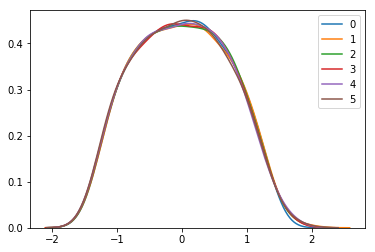

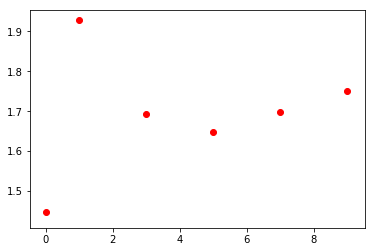

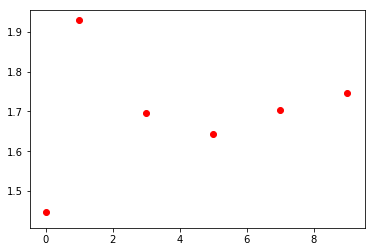

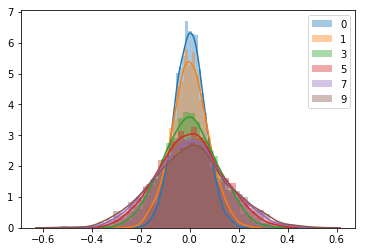

In [12]:
# The major effect is enlarging  Wah and increased max eigen value
for iters, trial in enumerate([0, 1, 3, 5, 7, 9]):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    plt.figure(0)
    sns.distplot(game.net.h2h.eig()[0].data.numpy()[:,0], hist = False, label = iters)
    plt.legend()
    # eigen value of internal matrix
    plt.figure(1)
    plt.scatter(trial, np.max(game.net.h2h.eig()[0].data.numpy()[:,0]), color = 'r')
    plt.figure(2)
    Weff = game.net.h2h + game.net.h2o.matmul(game.net.a2h)
    plt.scatter (trial, torch.max(Weff.eig()[0][:,0]).data.numpy(), color = 'r')
    plt.figure(3)
    # label str
    sns.distplot(game.net.a2h.data.numpy().ravel(), label = str(trial))
    plt.legend()

# Real Game Dynamics analysis  
The real game dynamcis shows huge difference performance in speed, stability of results, and also statistics of strategy 

**What is the relation to head direction, this order kept in limit cycle**
**Could we define the order parameter for behaviour and link it to dynamics?**

In [11]:
weight ='weights2/rnn_1515tanh512_checkpoint9_0_9'
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 1)
pregame.net.load_state_dict(torch.load(weight))
game = ValueMaxGame(grid_size = (50, 50), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=200,
                   lam = 0.)
grid = game.grid.grid.copy()
pca = PCA(file = 2, trial = 9, iters2=9)
pca.pca()

## Game Performance analysis

## Performance analysis
differ by speed, stability and final results on different sizes of arena, both for intra, and extrapolation

### analysis on early stage
**much faster learning speed of pretrained net on small size of arena, compare resutls on the first iteration for small and large size of arena. That rise in speed in small size is not necessarlily related to decoding, but should relie more dynamics **

In [5]:
# read all early performance small
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_0'.format(trial, i))
        Pretest.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_s_early_2.npy', Performance)

[[0.04793298038858345], [0.18382440476357925], [0.15336893481995056], [0.0068925289973384984], [0.4065389549384315]]
[[-0.08733175799649552], [0.16493920634027448], [0.42981877073401475], [-0.14010104779671184], [0.34582000672930685]]
[[0.21937872921334847], [0.6194150002061936], [0.37717759012247754], [0.03238986585974857], [-0.31822622069008066]]
[[0.5292987872560543], [0.4539569006150256], [0.45022431346292646], [0.6773417305409664], [0.3374136175898311]]
[[0.4369855974386086], [-0.016207810124619686], [0.47858172310333436], [0.009042388334031232], [0.4843036396151864]]
[[0.055491573585630505], [0.6788021634291248], [0.36825326996639224], [0.33000474269687113], [-0.074459592788191]]
[[-0.15804208502031927], [0.24274452262907575], [0.02652776705404643], [0.6696105976570048], [0.2513469404799829]]
[[0.1895290615435206], [0.2927224932214015], [0.07512435289719611], [0.24101869019547023], [0.2414638670443735]]
[[0.1976798706432587], [0.402801805178744], [0.31962008127549646], [0.5314214

In [7]:
# read all early performance large
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_0'.format(trial, i))
        Pretest.TestAllSizes(size_range = [55], limit_set = 8, test_size = 0)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_l_early_2.npy', Performance)

[[-0.6685634468533597], [-0.42919396627085793], [-0.5483459304104594], [-0.43783802275145733], [-0.31320810111760544]]
[[-0.4343130993894086], [-0.16072774813119584], [-0.43421218709889553], [-0.35858777873146097], [-0.37175369233354627]]
[[-0.48310431463813974], [-0.35580116832200515], [-0.31844789962924347], [-0.3838282425031174], [-0.4870284960463532]]
[[-0.4675533628173996], [-0.2023482937312188], [-0.2331040544876595], [-0.5008673651471716], [-0.4554398829158732]]
[[-0.3018591317438335], [-0.14690509790468725], [-0.5050855230175336], [-0.2615725116160677], [-0.30107265676789124]]
[[-0.588065928387981], [-0.4386591390189495], [-0.29484994288406896], [-0.004826231424604784], [-0.42910360858543073]]
[[-0.32107405512596], [-0.17395495050507392], [-0.36406400179491183], [-0.4403085708282035], [-0.4240808086939699]]
[[-0.1515837954399012], [-0.6418374778390441], [-0.644791405915295], [-0.558983305507402], [-0.48255643773521384]]
[[-0.25095777022668636], [-0.431957468611633], [-0.2662535

### analysis on late stage
**final learning results look similar to each other on small sizes, while 17 does seems more stable, on large size the 17 wins, while the best performance is similar**

In [5]:
# read all late performance small
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_9'.format(trial, i))
        Pretest.TestAllSizes(size_range = [10], limit_set = 4, test_size = 0)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_s_late_2.npy', Performance)

[[0.6109395942630984], [0.6987798099085286], [0.823994877319943], [0.602592441825899], [0.7555324402877834]]
[[0.7008359671452123], [0.666968005146966], [0.7157695225868288], [0.8864541732737434], [0.7507653647575169]]
[[0.8113279747113364], [0.5747768265668212], [0.8122694918103195], [0.6483399657914805], [0.6761568174793033]]
[[0.745454363039409], [0.6695526105370619], [0.8384299738014469], [0.712191933055437], [0.8714622997064172]]
[[0.6673838365536613], [0.7270719400183897], [0.7377083642607091], [0.5277031079080547], [0.31694350171189667]]
[[0.7489883323271206], [0.8245823087904083], [0.8558076859477788], [0.7424915951078925], [0.7270719867710911]]
[[0.6314652760399684], [0.7631839799159683], [0.8056880028690652], [0.8568196308207463], [0.9016775089861349]]
[[0.84142052733111], [0.8404830684369695], [0.8697002457242029], [0.8672931608116399], [0.8921371822559494]]
[[0.788274165640199], [0.7960950252238469], [0.7173497702446864], [0.6537529470032379], [0.8148782545853528]]


In [6]:
# read all late performance small
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_9'.format(trial, i))
        Pretest.TestAllSizes(size_range = [30], limit_set = 4, test_size = 1)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_m_late_2.npy', Performance)

[[0.21993830702372352], [-0.13481455220054822], [0.5829421259806871], [-0.2553080754913945], [-0.05770582818172834]]
[[0.27418790139105165], [0.09032483010076334], [0.06702343904992648], [0.23367219701417502], [0.09696170146474622]]
[[0.29266964130628015], [0.3137406659397416], [0.3112569110304415], [0.05176618534011333], [0.22618580895713672]]
[[0.24173162538538545], [0.13001239090628006], [0.18654540272017583], [0.41167886161242506], [0.40806177796892795]]
[[0.6473865577542967], [0.4929747638468067], [0.40945730522207535], [-0.36684413321541076], [-0.33950049815386546]]
[[0.4056840604687315], [0.010037561045757773], [0.34355789711152845], [0.4418201570701628], [-0.39986798541047125]]
[[0.0654629207746675], [0.1305847886784455], [0.207121319779699], [0.18188977493885677], [0.21153572602671852]]
[[-0.08411388401462527], [0.6213472906194972], [0.0878331184276253], [-0.1896001069391833], [0.3446986980598397]]
[[0.6749431721734089], [0.3935675590955672], [0.5956990602870913], [0.520499718

In [7]:
# read all late performance large
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_9'.format(trial, i))
        Pretest.TestAllSizes(size_range = [50], limit_set = 4, test_size = 2)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_l_late_2.npy', Performance)

[[-0.0784745874839068], [-0.42213080125013513], [0.06821533317370809], [-0.5864540502471627], [-0.37579224520251925]]
[[-0.1007996482428351], [-0.4297040485044091], [-0.32589598102468115], [-0.09797191572275828], [-0.3687408743614813]]
[[-0.23696211871979775], [-0.2508481177534121], [-0.35192157657867384], [-0.4813210571131535], [-0.1304943267845567]]
[[-0.04278479577246234], [-0.1969007238849209], [-0.2900992757637305], [-0.3497812754856953], [-0.006183778071142551]]
[[-0.02700749421424646], [0.02023445630923381], [-0.2456227253598345], [-0.4668150929324245], [-0.5631391653069646]]
[[-0.1193152727914698], [-0.6438697390253012], [-0.5824063981658338], [-0.09806359819542323], [-0.3511743124432754]]
[[-0.27330473104406416], [-0.2233898857992997], [-0.2657030809885884], [-0.2753024874706908], [-0.23444249100033365]]
[[-0.4220858127764355], [-0.00734557542910241], [-0.5666154404507198], [-0.531998637990409], [-0.11384495501523784]]
[[-0.26548119036543777], [-0.08525860266171817], [-0.09596

In [8]:
# read all late performance large
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_9'.format(trial, i))
        Pretest.TestAllSizes(size_range = [70], limit_set = 4, test_size = 3)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_exl_late_2.npy', Performance)

[[-0.37467214364436596], [-0.5264434646829659], [-0.04511118191961011], [-0.7325137340433319], [-0.6482023599623187]]
[[-0.35309344580092356], [-0.5378174594421863], [-0.5448427484102599], [-0.21678218613255393], [-0.48699766695877134]]
[[-0.4065050957501489], [-0.5361072233618474], [-0.5135712764538829], [-0.6033378993504497], [-0.46323008960567935]]
[[-0.2535744997653258], [-0.3904040169895731], [-0.5317300799838472], [-0.4828319560059122], [-0.44535102940404303]]
[[-0.23030262586532346], [-0.39231397724185313], [-0.4601590519940123], [-0.5854322420392852], [-0.6249640055518332]]
[[-0.5256282071810654], [-0.6780902370396527], [-0.7071685116409197], [-0.5474989203072649], [-0.40942570462686434]]
[[-0.47577189686039645], [-0.49968390339332025], [-0.5490211974257637], [-0.6094396717757021], [-0.552311543398855]]
[[-0.6288475719844154], [-0.24238685674364538], [-0.6347623101284816], [-0.5651323645581356], [-0.19478449330975173]]
[[-0.5700448377966527], [-0.4577354690157349], [-0.46036556

In [10]:
# read all late performance large
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_9'.format(trial, i))
        Pretest.TestAllSizes(size_range = [90], limit_set = 4, test_size = 4)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_exxl_late_2.npy', Performance)

[[-0.4431230924877245], [-0.6207495858736836], [-0.004954456994529288], [-0.7554085052918692], [-0.7470880911929956]]
[[-0.4777305605506317], [-0.5629909157688539], [-0.5688327094152094], [-0.29496309097821855], [-0.6552673594090169]]
[[-0.41188674785832485], [-0.5891769238823336], [-0.572813913075713], [-0.6653856975556713], [-0.4881310492220501]]
[[-0.5485628152691479], [-0.5714240240985058], [-0.5817656539221747], [-0.6036411332765155], [-0.5362715498593349]]
[[-0.33751659846272875], [-0.5003808465007292], [-0.5543520882525065], [-0.6504230724646547], [-0.6661517892036035]]
[[-0.5549516314053962], [-0.6753800490124277], [-0.6764874002806454], [-0.7037364604884837], [-0.5113029038674864]]
[[-0.5151320868897091], [-0.6121390865132447], [-0.6808564728855493], [-0.6161924082878647], [-0.6662669554891438]]
[[-0.64870789251754], [-0.2967723323749351], [-0.6474206609167603], [-0.6484375871912356], [-0.4965644265316791]]
[[-0.6884256348244986], [-0.6478088304388462], [-0.5091706720221317], 

In [6]:
# read all late performance large
Performance = []
for trial in [9, 13, 15, 17, 19, 21, 31, 36, 38]:
    performance = []
    for i in range(5):
        Pretest = PretrainTest(weight_read='weights2/rnn_1515tanh512_checkpoint{}_{}_9'.format(trial, i))
        Pretest.TestAllSizes(size_range = [150], limit_set = 8, test_size = 7)
        performance.append(Pretest.Performance)
    print (performance)
    Performance.append(performance)
    np.save('performance_exxxl_late_2.npy', Performance)

[[-0.5809781381318702], [-0.7219120603570688], [-0.018547949148668197], [-0.7968015195208518], [-0.781316458233666]]
[[-0.12076445029896163], [-0.5528362217000544], [-0.6869436519520903], [-0.3805518486761102], [-0.657441032479262]]
[[-0.4914642542027905], [-0.7457508891770084], [-0.5196955548096664], [-0.7661627878478083], [-0.5331468795962886]]
[[-0.6699761790143641], [-0.6533719786970194], [-0.6724876501714789], [-0.625613929260072], [-0.5942296709112584]]
[[-0.26088420580133476], [-0.5900600706426341], [-0.45513826001322555], [-0.6731689285584939], [-0.7220677688585126]]
[[-0.6661197670798489], [-0.7487280807847156], [-0.7970001815334147], [-0.7223441678702962], [-0.48849457437270283]]
[[-0.538431731973304], [-0.5996767999727745], [-0.6982132068780236], [-0.742697405697778], [-0.7410832346957625]]
[[-0.7057269753193863], [-0.36477114808729066], [-0.7464731603679069], [-0.7038558109711571], [-0.4936355875747964]]
[[-0.7411206866432543], [-0.6811803615656618], [-0.35846085558959967],

## Real game analysis 
**The behaviour is best analyzed by pwd and methods in different sizes of arena, in order to see the strategy is mediated by which loop, the big enviromental feedback(low freq related to size) or small action feedbakd(high freq)**

we take what shows good performance and send it for analysis 


(0, 0.1)

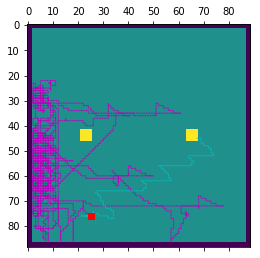

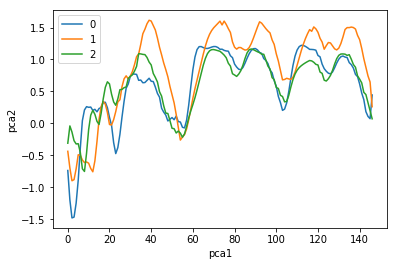

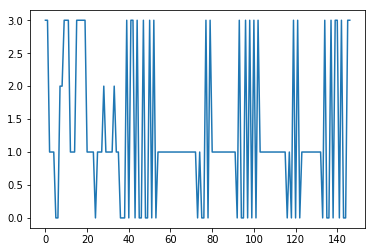

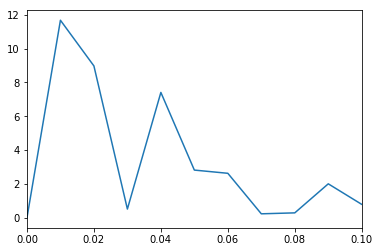

In [24]:
size = 85
PC_traces = []
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    weight ='weights2/rnn_1515tanh512_checkpoint13_3_9'
    game = ValueMaxGame(pregame.net, grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, reward1 = trajectory(game, start, reward_control = 0, size = size)
    Pos2, hidden2, dH2, Action, reward2 = trajectory(game, start, reward_control = 1, size = size)
   
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

    PC_traces1 = (pca.vect[:10] @ hidden1.T)
    PC_traces2 = (pca.vect[:10] @ hidden2.T)
    if reward1 == 1: 
        PC_traces.extend(PC_traces1[0])
    if reward2 == 1:
        PC_traces.extend(PC_traces2[0])
    if i == 0:
        plt.figure()
        for pc in [0, 1, 2]:
            plt.plot(PC_traces2[pc], label = pc)
        plt.legend()
        plt.xlabel('pca1')
        plt.ylabel('pca2')
        plt.figure()
        plt.plot(Action)
ff, pd = signal.periodogram(np.array(PC_traces), nfft = 100)
plt.figure()
plt.plot(ff, pd)
plt.xlim(0 , 0.1)

(0, 0.1)

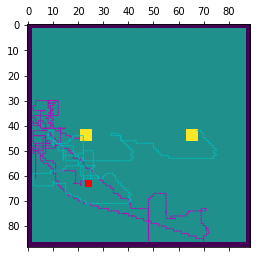

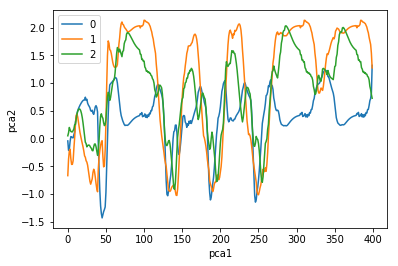

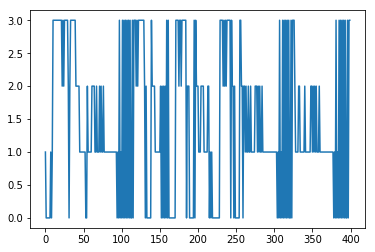

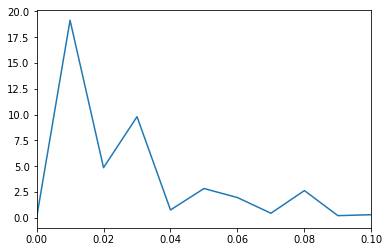

In [27]:
size = 85
PC_traces = []
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    weight ='weights2/rnn_1515tanh512_checkpoint13_0_9'
    game = ValueMaxGame(pregame.net, grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, reward1 = trajectory(game, start, reward_control = 0, size = size)
    Pos2, hidden2, dH2, Action, reward2 = trajectory(game, start, reward_control = 1, size = size)
   
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

    PC_traces1 = (pca.vect[:10] @ hidden1.T)
    PC_traces2 = (pca.vect[:10] @ hidden2.T)
    if reward1 == 1: 
        PC_traces.extend(PC_traces1[0])
    if reward2 == 1:
        PC_traces.extend(PC_traces2[0])
    if i == 0:
        plt.figure()
        for pc in [0, 1, 2]:
            plt.plot(PC_traces2[pc], label = pc)
        plt.legend()
        plt.xlabel('pca1')
        plt.ylabel('pca2')
        plt.figure()
        plt.plot(Action)
ff, pd = signal.periodogram(np.array(PC_traces), nfft = 100)
plt.figure()
plt.plot(ff, pd)
plt.xlim(0 , 0.1)

(0, 0.1)

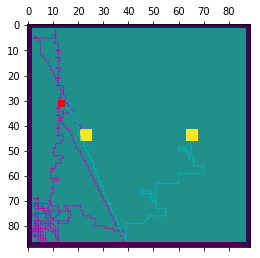

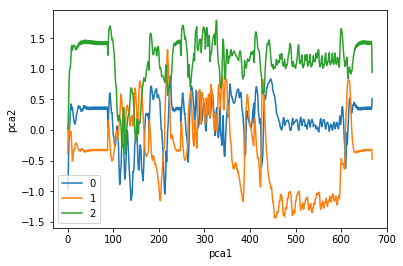

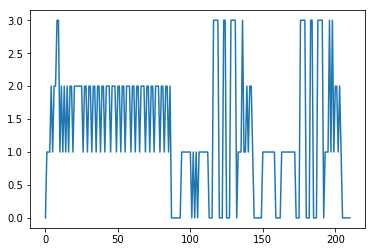

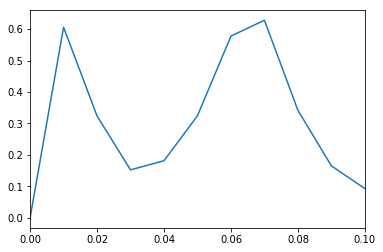

In [32]:
size = 85
PC_traces = []
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    weight ='weights2/rnn_1515tanh512_checkpoint38_3_9'
    game = ValueMaxGame(pregame.net, grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, reward1 = trajectory(game, start, reward_control = 0, size = size)
    Pos2, hidden2, dH2, Action, reward2 = trajectory(game, start, reward_control = 1, size = size)
   
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

    PC_traces1 = (pca.vect[:10] @ hidden1.T)
    PC_traces2 = (pca.vect[:10] @ hidden2.T)
    if reward1 == 1: 
        PC_traces.extend(PC_traces1[0])
    if reward2 == 1:
        PC_traces.extend(PC_traces2[0])
    if i == 0:
        plt.figure()
        for pc in [0, 1, 2]:
            plt.plot(PC_traces1[pc], label = pc)
        plt.legend()
        plt.xlabel('pca1')
        plt.ylabel('pca2')
        plt.figure()
        plt.plot(Action)
ff, pd = signal.periodogram(np.array(PC_traces), nfft = 100)
plt.figure()
plt.plot(ff, pd)
plt.xlim(0 , 0.1)

(0, 0.1)

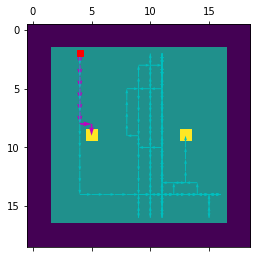

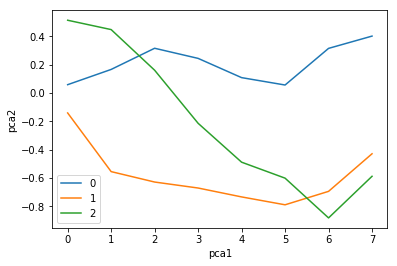

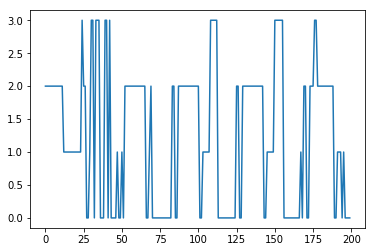

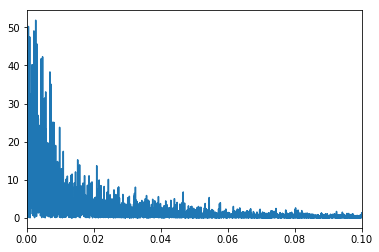

In [243]:
size = 15
PC_traces = []
for i in range(500):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    weight ='weights2/rnn_1515tanh512_checkpoint1_0_9'
    game = ValueMaxGame(pregame.net, grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0)
    Pos2, hidden2, dH2, Action, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0)
   
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

    PC_traces1 = (pca.vect[:10] @ hidden1.T)
    PC_traces2 = (pca.vect[:10] @ hidden2.T)
    if reward1 == 1: 
        PC_traces.extend(PC_traces1[0])
    if reward2 == 1:
        PC_traces.extend(PC_traces2[0])
    if i == 0:
        plt.figure()
        for pc in [0, 1, 2]:
            plt.plot(PC_traces1[pc], label = pc)
        plt.legend()
        plt.xlabel('pca1')
        plt.ylabel('pca2')
        plt.figure()
        plt.plot(Action)
ff, pd = signal.periodogram(np.array(PC_traces))
plt.figure()
plt.plot(ff, pd)
plt.xlim(0 , 0.1)

**right corner is used as strategical point**
**First time to see limit cycle used that way, think a bit outside navigation, limit cycle can characterize different features, for example orientation here , it is only one example. Need to check limit cycle used in general neuroscience**

**The solution we see is a cross scale solution,  we have the limit cycles for larger size arena, and during one limit cycle , the trace is for scaning micro space corresponding to strategy in smaller arena**

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**